# Машинное обучение для выявления торговли по непубличной информации в упрощённой книге лимитных заявок

В этом ноутбуке мы строим сквозной учебный пример «надзорного контура»:

1. **Моделируем книгу лимитных заявок** (limit order book) по одному активу
   с несколькими типами участников:
   - «Шумовые» трейдеры (случайные участники)
   - Маркет-мейкеры
   - Проп-трейдеры (законные спекулянты)
   - Разные типы незаконных участников, торгующих по непубличной информации,
     и манипуляторов

2. **Генерируем синтетические торговые данные** в большом числе рыночных сценариев.

3. **Извлекаем признаки** на двух уровнях:
   - Для каждого агента (например, объём, позиции, прибыль/убыток).
   - Для временных окон (например, волатильность, объём, наличие незаконных сделок).

4. **Обучаем модель машинного обучения**, задача которой — выявлять подозрительных
   агентов по их торговому поведению.

5. **Интерпретируем модель** и обсуждаем, что именно она «выучила»,
   включая типичные ловушки и искажения.

Это не реальная система надзора. Цель — создать **контролируемый учебный стенд**,
где видно, как поведение, похожее на торговлю по непубличной информации, оставляет
статистический след и как модель машинного обучения может его уловить.

In [1]:
import random
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Для воспроизводимости результатов
random.seed(42)
np.random.seed(42)

## Базовые структуры книги лимитных заявок

Начнём с **книги заявок** — движка сопоставления заявок в нашей моделируемой торговой системе.

Основные понятия:

- **Заявка (Order)** — распоряжение купить или продать некоторый объём по заданной цене
  (или по рыночной цене).
- **Книга заявок (Order book)** — две отсортированные очереди:
  - **Bids**: лимитные заявки на покупку, отсортированные по цене по убыванию,
    при равной цене — по времени по возрастанию.
  - **Asks**: лимитные заявки на продажу, отсортированные по цене по возрастанию,
    при равной цене — по времени по возрастанию.
- **Серединная цена (mid-price)** — среднее между лучшей ценой покупки и лучшей ценой продажи;
  если книга пуста, используем фундаментальную (теоретическую) стоимость.

Задачи класса `OrderBook`:

- Поддерживать очереди заявок на покупку и продажу.
- Вставлять новые лимитные заявки с приоритетом «цена–время».
- Сопоставлять входящие заявки с имеющимися и формировать **сделки**.
- Предоставлять вспомогательные методы: лучшая покупка/продажа и серединная цена.

В итоге получается минимальная, но реалистичная микроструктура рынка,
в которой можно «торговать».

In [2]:
@dataclass
class Order:
    id: int
    time: int
    agent_id: int
    side: str  # "BUY" или "SELL"
    price: Optional[float]  # None для рыночной заявки
    quantity: int
    is_market: bool = False


class OrderBook:
    def __init__(self):
        # Отсортировано по цене по убыванию, при равной цене — по времени по возрастанию
        self.bids: List[Order] = []
        # Отсортировано по цене по возрастанию, при равной цене — по времени по возрастанию
        self.asks: List[Order] = []
        self.order_lookup: Dict[int, Order] = {}
        self.trades: List[Dict[str, Any]] = []

    # --- Лучшие котировки и серединная цена ---

    def best_bid(self) -> Optional[Order]:
        return self.bids[0] if self.bids else None

    def best_ask(self) -> Optional[Order]:
        return self.asks[0] if self.asks else None

    def mid_price(self, fallback_price: float) -> float:
        """
        Серединная цена на основе лучшей покупки/продажи.
        Если книга пуста, используется fallback_price
        (обычно текущая фундаментальная стоимость).
        """
        bid = self.best_bid()
        ask = self.best_ask()
        if bid is None and ask is None:
            return fallback_price
        if bid is None:
            return ask.price
        if ask is None:
            return bid.price
        return 0.5 * (bid.price + ask.price)

    # --- Вспомогательные методы управления заявками ---

    def cancel_agent_orders(self, agent_id: int):
        """Удалить все выставленные ранее заявки, принадлежащие заданному агенту."""
        self.bids = [o for o in self.bids if o.agent_id != agent_id]
        self.asks = [o for o in self.asks if o.agent_id != agent_id]
        to_delete = [oid for oid, o in self.order_lookup.items() if o.agent_id == agent_id]
        for oid in to_delete:
            del self.order_lookup[oid]

    def _add_limit_order_to_book(self, order: Order):
        book_side = self.bids if order.side == "BUY" else self.asks
        inserted = False

        for i, existing in enumerate(book_side):
            if order.side == "BUY":
                # Сначала более высокая цена; при одинаковой цене — более раннее время
                if (order.price > existing.price) or (
                        order.price == existing.price and order.time < existing.time
                ):
                    book_side.insert(i, order)
                    inserted = True
                    break
            else:  # SELL
                # Сначала более низкая цена; при одинаковой цене — более раннее время
                if (order.price < existing.price) or (
                        order.price == existing.price and order.time < existing.time
                ):
                    book_side.insert(i, order)
                    inserted = True
                    break

        if not inserted:
            book_side.append(order)

        self.order_lookup[order.id] = order

    # --- Основная логика сопоставления заявок ---

    def process_order(self, order: Order) -> List[Dict[str, Any]]:
        """
        Сопоставить входящую заявку с заявками в книге.
        При необходимости (для лимитной заявки) добавить невыполненный остаток в книгу.
        Возвращает список сформированных сделок.
        """
        trades: List[Dict[str, Any]] = []
        remaining_qty = order.quantity

        if order.side == "BUY":
            book_side = self.asks

            def crossing(best: Order) -> bool:
                if order.is_market:
                    return True
                return order.price is not None and order.price >= best.price

        else:  # SELL
            book_side = self.bids

            def crossing(best: Order) -> bool:
                if order.is_market:
                    return True
                return order.price is not None and order.price <= best.price

        # Сопоставление с противоположной стороной книги
        while remaining_qty > 0 and book_side:
            best = book_side[0]
            if not crossing(best):
                break

            trade_qty = min(remaining_qty, best.quantity)
            trade_price = best.price  # сделка по цене встречной (заявки из книги)
            remaining_qty -= trade_qty
            best.quantity -= trade_qty

            # Фиксируем участников сделки
            if order.side == "BUY":
                buy_id = order.agent_id
                sell_id = best.agent_id
            else:
                buy_id = best.agent_id
                sell_id = order.agent_id

            trade = {
                "time": order.time,
                "price": trade_price,
                "quantity": trade_qty,
                "buy_agent": buy_id,
                "sell_agent": sell_id,
            }
            trades.append(trade)
            self.trades.append(trade)

            # Полностью исполненная встречная заявка удаляется из книги
            if best.quantity == 0:
                self.order_lookup.pop(best.id, None)
                book_side.pop(0)

        # Если это лимитная заявка и остался неисполненный объём — добавляем в книгу
        if (not order.is_market) and remaining_qty > 0:
            order.quantity = remaining_qty
            self._add_limit_order_to_book(order)

        return trades

## Агенты и единый интерфейс

Каждый участник торгов в нашей модели — это **агент**:

- У каждого агента есть **денежные средства** и **позиция** по активу.
- На каждом шаге по времени агенту предлагается сформировать **заявки** (метод `step`).
- Когда совершается сделка, вызывается метод `on_trade`, который обновляет денежный
  результат и позицию.

Дополнительно мы присваиваем агентам **метки** для задач машинного обучения:
- `label_is_illegal`: является ли агент незаконным участником
  (торгующим по непубличной информации или манипулятором).
- `label_illegal_type`: тип незаконной стратегии (трейдинг перед событием,
  схема «накачка–сброс» и т.п.).
- `group_id`: идентификатор группы для согласованных действий (кольцевая схема).

Все конкретные типы агентов наследуются от этого базового класса и реализуют
собственное поведение в методе `step`.

In [3]:
class Agent:
    """
    Базовый класс для всех агентов.
    """

    def __init__(self, agent_id: int, agent_type: str):
        self.id = agent_id
        self.type = agent_type  # например, "NOISE", "MM", "PROP", "INSIDER"
        self.cash = 0.0
        self.position = 0
        self.trade_history: List[Dict[str, Any]] = []

        # Метки для задач обнаружения нарушений
        self.label_is_illegal: bool = False
        self.label_illegal_type: Optional[str] = None  # например, "event_insider", "pump"
        self.group_id: Optional[int] = None  # для колец / групп

    def step(
            self,
            t: int,
            book: OrderBook,
            fundamental: float,
            mid_price: float,
    ) -> List[Dict[str, Any]]:
        """
        Вернуть список заявок (в виде словарей) на текущем шаге времени.
        В базовом классе агент ничего не делает.
        """
        return []

    def on_trade(self, price: float, quantity: int, side: str):
        """
        Обновить денежный результат и позицию, если агент участвовал в сделке.
        side — "BUY" или "SELL" с точки зрения данного агента.
        """
        if side == "BUY":
            self.position += quantity
            self.cash -= price * quantity
        else:  # SELL
            self.position -= quantity
            self.cash += price * quantity

        self.trade_history.append(
            {"price": price, "quantity": quantity, "side": side}
        )

### «Шумовые» трейдеры

«Шумовые» трейдеры моделируют **неинформированный, случайный поток заявок**:
- С вероятностью `p_trade` они выставляют заявку на каждом шаге времени.
- Направление (покупка/продажа) выбирается случайно
  (с небольшой дополнительной асимметрией по `direction_bias`, если задана).
- Случайно выбирается тип заявки: **рыночная или лимитная**.
- Лимитные заявки выставляются около текущей серединной цены с небольшим шумом.

Зачем они нужны:
- Формируют фон ликвидности и случайности.
- Делают поведение незаконных участников менее очевидным по сравнению с
  тривиально пустым рынком.

In [4]:
class NoiseTrader(Agent):
    def __init__(
            self,
            agent_id: int,
            p_trade: float = 0.2,
            p_market: float = 0.5,
            max_qty: int = 10,
            direction_bias: float = 0.0,  # >0 = небольшой сдвиг в сторону покупок, <0 = в сторону продаж
    ):
        super().__init__(agent_id, agent_type="NOISE")
        self.p_trade = p_trade
        self.p_market = p_market
        self.max_qty = max_qty
        self.direction_bias = direction_bias

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        if random.random() > self.p_trade:
            return []

        # Направление: случайное с учётом возможного смещения
        base = random.random() - 0.5 + self.direction_bias
        side = "BUY" if base >= 0 else "SELL"

        quantity = random.randint(1, self.max_qty)
        is_market = random.random() < self.p_market

        if is_market:
            price = None
        else:
            # Лимитная цена вокруг серединной с небольшим шумом
            spread = 0.002  # 0,2 %
            noise = np.random.normal(0, spread)
            if side == "BUY":
                price = mid_price * (1 - abs(noise))
            else:
                price = mid_price * (1 + abs(noise))
            price = round(float(price), 2)

        return [
            {
                "side": side,
                "quantity": quantity,
                "price": price,
                "is_market": is_market,
            }
        ]

### Маркет-мейкеры

Маркет-мейкер постоянно выставляет котировки **покупки и продажи**:
- На каждом шаге он снимает свои старые заявки и выставляет новые.
- Цены заявок симметрично расположены вокруг текущей серединной цены
  с заданным **спрэдом**.
- Управляет **инвентарным риском**: при большой длинной/короткой позиции слегка
  сдвигает котировки.
- Имеет ограничение `max_inventory`, чтобы не накапливать чрезмерные позиции.

Роль маркет-мейкера:
- Обеспечивает узкий спред и глубину книги заявок.
- Совершает много сделок, стремясь к **нейтральной позиции** и зарабатывая на спрэде.
- Служит хорошей точкой сравнения с незаконными участниками, имеющими направленную позицию.

In [5]:
class MarketMaker(Agent):
    def __init__(
            self,
            agent_id: int,
            spread: float = 0.002,  # половина спрэда (0,2 %)
            size: int = 20,
            max_inventory: int = 200,
    ):
        super().__init__(agent_id, agent_type="MM")
        self.spread = spread
        self.size = size
        self.max_inventory = max_inventory

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        # Сначала снимаем все ранее выставленные заявки данного маркет-мейкера
        book.cancel_agent_orders(self.id)

        # Небольшой сдвиг котировок в зависимости от позиции
        inventory_skew = 0.001 * self.position  # чем длиннее позиция, тем выше ask и ниже bid
        bid_price = mid_price * (1 - self.spread - inventory_skew)
        ask_price = mid_price * (1 + self.spread - inventory_skew)

        bid_price = round(float(bid_price), 2)
        ask_price = round(float(ask_price), 2)

        orders: List[Dict[str, Any]] = []

        if self.position < self.max_inventory:
            orders.append(
                {
                    "side": "BUY",
                    "quantity": self.size,
                    "price": bid_price,
                    "is_market": False,
                }
            )
        if self.position > -self.max_inventory:
            orders.append(
                {
                    "side": "SELL",
                    "quantity": self.size,
                    "price": ask_price,
                    "is_market": False,
                }
            )

        return orders

### Проп-трейдеры (законные спекулянты)

Проп-трейдеры — это **законные спекулятивные участники**,
которые пытаются использовать краткосрочные ценовые закономерности:
- Режим **momentum**: покупают при росте цены и продают при падении.
- Режим **mean_reversion**: делают противоположное (покупают после падения,
  продают после роста).
- Совершают сделки с вероятностью `p_trade`, если произошёл достаточно заметный
  ценовой сдвиг.

Зачем они нужны в модели:
- Вносят **интенсивное, направленное, но законное** поведение.
- Не позволяют модели слишком легко приравнять «направленный трейдинг»
  к «незаконной торговле».

In [6]:
class PropTrader(Agent):
    def __init__(
            self,
            agent_id: int,
            mode: str = "momentum",  # или "mean_reversion"
            p_trade: float = 0.3,
            max_qty: int = 15,
    ):
        super().__init__(agent_id, agent_type="PROP")
        assert mode in ("momentum", "mean_reversion")
        self.mode = mode
        self.p_trade = p_trade
        self.max_qty = max_qty
        self.last_mid: Optional[float] = None

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        # Нужна хотя бы одна предыдущая серединная цена, чтобы оценить направление движения
        if self.last_mid is None:
            self.last_mid = mid_price
            return []

        if random.random() > self.p_trade:
            self.last_mid = mid_price
            return []

        price_change = mid_price - self.last_mid
        if abs(price_change) < 1e-6:
            self.last_mid = mid_price
            return []

        # Направление сделки в зависимости от простого ценового изменения
        if self.mode == "momentum":
            side = "BUY" if price_change > 0 else "SELL"
        else:  # mean_reversion
            side = "SELL" if price_change > 0 else "BUY"

        quantity = random.randint(1, self.max_qty)
        is_market = random.random() < 0.6  # достаточно агрессивный стиль

        if is_market:
            price = None
        else:
            # Лимитная заявка чуть внутри текущего спрэда
            if side == "BUY":
                price = mid_price * 0.999
            else:
                price = mid_price * 1.001
            price = round(float(price), 2)

        self.last_mid = mid_price

        return [
            {
                "side": side,
                "quantity": quantity,
                "price": price,
                "is_market": is_market,
            }
        ]

## Незаконные стратегии: торговля по непубличной информации и манипуляции

Все незаконные стратегии имеют общие элементы:
- Для них установлена метка `label_is_illegal = True`.
- Они могут входить в состав **группы / кольца** (`group_id`).
- Часть стратегий привязана к **фундаментальному событию**
  (например, неожиданная отчётность), для которого известны:
  - `event_time` — момент события;
  - `direction` — направление изменения стоимости
    (+1 — «хорошие новости» / рост цены, −1 — «плохие новости» / падение).

Класс `InsiderBase` собирает эту общую информацию.
Конкретные стратегии реализуют собственную логику в методе `step`.

In [7]:
class InsiderBase(Agent):
    """
    Базовый класс для всех стратегий, основанных на непубличной информации
    или манипулирующих ценой.
    """

    def __init__(
            self,
            agent_id: int,
            scenario_name: str,
            group_id: Optional[int] = None,
            event_time: Optional[int] = None,
            direction: int = 1,
    ):
        super().__init__(agent_id, agent_type="INSIDER")
        self.label_is_illegal = True
        self.label_illegal_type = scenario_name
        self.group_id = group_id
        self.event_time = event_time
        self.direction = direction  # +1 — вверх, -1 — вниз

    # step() реализуется в подклассах

### Инсайдеры перед событием и «медленные» инсайдеры

Сначала определим два вида **информационных инсайдеров**, торгующих вокруг известного события:
1. `EventInsider`
   - Начинает торговать вскоре до события.
   - Наращивает направленную позицию (длинную при хороших новостях, короткую — при плохих).
   - Затем постепенно закрывает её в течение заданного горизонта после события.
2. `SlowInsider`
   - Начинает значительно раньше события.
   - Торгует меньшими объёмами и с меньшей частотой.
   - В основном использует лимитные заявки, поэтому выглядит более «терпеливым» участником.

В обоих случаях ключевая идея:
> *«Заранее занять позицию в направлении будущего фундаментального скачка,
>  пока остальной рынок ещё ничего не знает»*.

In [8]:
class EventInsider(InsiderBase):
    """
    Классический «короткий» инсайдер вокруг события:
    - наращивает направленную позицию до момента event_time,
    - закрывает её в течение конечного горизонта после события.
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            trade_size: int = 10,
            unwind_horizon: int = 80,
            group_id: Optional[int] = None,
    ):
        super().__init__(
            agent_id,
            scenario_name="event_insider",
            group_id=group_id,
            event_time=event_time,
            direction=direction,
        )
        self.trade_size = trade_size
        self.unwind_horizon = unwind_horizon
        self.start_time = start_time if start_time is not None else max(0, event_time - 50)

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        # До стартового момента агент не торгует
        if t < self.start_time:
            return orders

        # Фаза накопления позиции до события
        if self.start_time <= t < self.event_time:
            side = "BUY" if self.direction > 0 else "SELL"
            is_market = random.random() < 0.3
            if is_market:
                price = None
            else:
                # Относительно агрессивная лимитная заявка около серединной цены
                if side == "BUY":
                    price = mid_price * 1.001
                else:
                    price = mid_price * 0.999
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": self.trade_size,
                    "price": price,
                    "is_market": is_market,
                }
            )

        # Фаза закрытия позиции после события
        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # Если событие положительное, у инсайдера, скорее всего, длинная позиция -> он продаёт.
            # Если отрицательное — короткая позиция -> он откупает.
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.trade_size, abs(self.position))
            else:
                return orders

            is_market = True  # агрессивно закрываем позицию
            price = None

            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders


class SlowInsider(InsiderBase):
    """
    «Медленный» инсайдер с длинным горизонтом:
    - начинает значительно раньше события,
    - торгует меньшими объёмами и с меньшей интенсивностью,
    - в основном использует лимитные заявки рядом с ценами в книге.
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            max_trade_size: int = 6,
            p_trade_pre: float = 0.3,
            unwind_horizon: int = 120,
    ):
        super().__init__(
            agent_id,
            scenario_name="slow_insider",
            event_time=event_time,
            direction=direction,
        )
        self.max_trade_size = max_trade_size
        self.p_trade_pre = p_trade_pre
        self.unwind_horizon = unwind_horizon
        if start_time is None:
            self.start_time = max(0, event_time - 300)
        else:
            self.start_time = start_time

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        if t < self.start_time:
            return orders

        if self.start_time <= t < self.event_time:
            if random.random() > self.p_trade_pre:
                return orders
            side = "BUY" if self.direction > 0 else "SELL"
            quantity = random.randint(1, self.max_trade_size)
            # Преимущественно лимитные заявки; иногда — рыночные
            is_market = random.random() < 0.1
            if is_market:
                price = None
            else:
                # Лимитная заявка около серединной цены с небольшим отступом
                spread = 0.0015
                if side == "BUY":
                    price = mid_price * (1 - spread)
                else:
                    price = mid_price * (1 + spread)
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # Постепенное закрытие позиции в зависимости от текущего объёма
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.max_trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.max_trade_size, abs(self.position))
            else:
                return orders

            is_market = random.random() < 0.5
            if is_market:
                price = None
            else:
                if side == "SELL":
                    price = mid_price * 0.999
                else:
                    price = mid_price * 1.001
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders

### «Скрытные» инсайдеры и манипуляторы по схеме «накачка–сброс»
Далее добавим два более изощрённых типа нарушителей:
1. `StealthInsider`
   - В большинстве случаев торгует в информированном направлении.
   - Периодически делает **«маскирующие» сделки** в противоположном направлении.
   - Использует немного иные уровни цен для маскирующих сделок, чтобы выглядеть
     менее подозрительно.

   Идея: сделать поток заявок менее односторонним, но при этом постепенно
   наращивать целевую позицию.

2. `PumpAndDumpManipulator`
   - Не опирается на фундаментальную информацию.
   - Начинает в момент `start_time`.
   - Фаза **«накачки»**: агрессивно покупает (или продаёт), уводя цену от равновесия.
   - Фаза **«сброса»**: закрывает позицию, по возможности фиксируя прибыль.

In [9]:
class StealthInsider(InsiderBase):
    """
    «Скрытный» инсайдер:
    - смешивает информированные сделки с периодическими «маскирующими»
      сделками в противоположном направлении;
    - торгует с умеренной интенсивностью, разбивая объёмы на части.
    """

    def __init__(
            self,
            agent_id: int,
            event_time: int,
            direction: int = 1,
            start_time: Optional[int] = None,
            max_trade_size: int = 8,
            p_trade_pre: float = 0.4,
            decoy_prob: float = 0.15,
            unwind_horizon: int = 80,
    ):
        super().__init__(
            agent_id,
            scenario_name="stealth_insider",
            event_time=event_time,
            direction=direction,
        )
        self.max_trade_size = max_trade_size
        self.p_trade_pre = p_trade_pre
        self.decoy_prob = decoy_prob
        self.unwind_horizon = unwind_horizon
        if start_time is None:
            self.start_time = max(0, event_time - 120)
        else:
            self.start_time = start_time

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if self.event_time is None:
            return orders

        if t < self.start_time:
            return orders

        if self.start_time <= t < self.event_time:
            if random.random() > self.p_trade_pre:
                return orders

            informed_side = "BUY" if self.direction > 0 else "SELL"
            is_decoy = random.random() < self.decoy_prob
            side = "SELL" if (informed_side == "BUY" and is_decoy) else "BUY" if (
                    informed_side == "SELL" and is_decoy) else informed_side

            quantity = random.randint(1, self.max_trade_size)
            is_market = random.random() < 0.4

            if is_market:
                price = None
            else:
                # Лимитные заявки около серединной цены; маскирующие могут быть чуть дальше
                offset = 0.001 if not is_decoy else 0.002
                if side == "BUY":
                    price = mid_price * (1 - offset)
                else:
                    price = mid_price * (1 + offset)
                price = round(float(price), 2)

            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        elif self.event_time <= t < self.event_time + self.unwind_horizon:
            # Фаза закрытия позиции, похожая на EventInsider
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.max_trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.max_trade_size, abs(self.position))
            else:
                return orders

            is_market = True
            price = None
            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders


class PumpAndDumpManipulator(InsiderBase):
    """
    Манипулятор по схеме «накачка–сброс»:
    - фундаментального события может не быть;
    - в фазе «накачки» агрессивно толкает цену в одну сторону;
    - затем закрывает позицию в фазе «сброса».
    """

    def __init__(
            self,
            agent_id: int,
            start_time: int,
            direction: int = 1,  # +1 — накачка вверх, -1 — вниз
            pump_horizon: int = 80,
            unwind_horizon: int = 80,
            trade_size: int = 12,
            group_id: Optional[int] = None,
    ):
        super().__init__(
            agent_id,
            scenario_name="pump_and_dump",
            group_id=group_id,
            event_time=None,
            direction=direction,
        )
        self.start_time = start_time
        self.pump_horizon = pump_horizon
        self.unwind_horizon = unwind_horizon
        self.trade_size = trade_size

    def step(self, t: int, book: OrderBook, fundamental: float, mid_price: float) -> List[Dict[str, Any]]:
        orders: List[Dict[str, Any]] = []

        if t < self.start_time:
            return orders

        # Фаза «накачки»
        if self.start_time <= t < self.start_time + self.pump_horizon:
            side = "BUY" if self.direction > 0 else "SELL"
            quantity = self.trade_size
            is_market = random.random() < 0.7  # очень агрессивный стиль
            if is_market:
                price = None
            else:
                if side == "BUY":
                    price = mid_price * 1.002
                else:
                    price = mid_price * 0.998
                price = round(float(price), 2)
            orders.append(
                {
                    "side": side,
                    "quantity": quantity,
                    "price": price,
                    "is_market": is_market,
                }
            )

        # Фаза «сброса»
        elif self.start_time + self.pump_horizon <= t < self.start_time + self.pump_horizon + self.unwind_horizon:
            if self.direction > 0 and self.position > 0:
                side = "SELL"
                qty = min(self.trade_size, self.position)
            elif self.direction < 0 and self.position < 0:
                side = "BUY"
                qty = min(self.trade_size, abs(self.position))
            else:
                return orders

            is_market = True
            price = None
            orders.append(
                {
                    "side": side,
                    "quantity": qty,
                    "price": price,
                    "is_market": is_market,
                }
            )

        return orders

## Конфигурация симуляции и генератор сценариев

Вместо того чтобы каждый раз вручную задавать один конкретный рыночный сценарий,
введём абстракцию конфигурации:
- `SimulationConfig` описывает один прогон «мира»:
  - длину временного ряда `T`;
  - наличие **фундаментального события** (скачок истинной стоимости);
  - момент события и величину/направление скачка;
  - количество шумовых трейдеров, маркет-мейкеров, проп-трейдеров;
  - список объектов `InsiderSpec`, описывающих незаконных агентов (если они есть).
- `InsiderSpec` — простая структура, задающая тип незаконного агента
  (стратегия, идентификатор группы и т.п.).

Вспомогательная функция `sample_random_config(run_id)` случайным образом
формирует правдоподобный сценарий:
- в части прогонов есть фундаментальное событие, в части — нет;
- событие может быть вверх или вниз, случаться рано или поздно;
- в некоторых прогонах есть инсайдеры, в некоторых — нет (условно «чистый» рынок);
- иногда вместо инсайдеров вокруг события добавляем манипуляторов
  по схеме «накачка–сброс».

За счёт многократного случайного выбора конфигураций мы получаем
**разнообразный обучающий набор** сценариев.

In [10]:
@dataclass
class InsiderSpec:
    """
    Конфигурация одного незаконного агента в рамках сценария.
    """
    strategy: str  # "event", "slow", "stealth", "ring", "pump"
    start_time: Optional[int] = None
    trade_size: Optional[int] = None
    group_id: Optional[int] = None


@dataclass
class SimulationConfig:
    run_id: int
    T: int = 1000
    has_event: bool = True
    event_time: Optional[int] = None
    jump_size: float = 0.1  # абсолютная величина скачка, знак задаётся jump_direction
    jump_direction: int = 1  # +1 или -1
    volatility: float = 0.05  # стандартное отклонение случайного блуждания фундаментальной стоимости
    n_noise_traders: int = 20
    n_market_makers: int = 1
    n_prop_traders: int = 0
    insider_specs: List[InsiderSpec] = field(default_factory=list)


def sample_random_config(run_id: int) -> SimulationConfig:
    """
    Случайным образом сгенерировать конфигурацию сценария, включая:
    - наличие или отсутствие фундаментального события;
    - количество и типы инсайдеров (возможен вариант «никого нет»);
    - состав прочих участников (шумовые трейдеры, маркет-мейкеры, проп-трейдеры).
    """
    T = random.randint(800, 1500)

    has_event = random.random() < 0.7  # в ~70 % прогонов есть фундаментальное событие
    if has_event:
        event_time = random.randint(int(0.3 * T), int(0.8 * T))
        jump_size = random.uniform(0.05, 0.2)  # скачок 5–20 %
        jump_direction = random.choice([-1, 1])
    else:
        event_time = None
        jump_size = 0.0
        jump_direction = 0

    n_noise_traders = random.randint(10, 40)
    n_market_makers = random.choice([1, 2])
    n_prop_traders = random.choice([0, 1, 2])

    insider_specs: List[InsiderSpec] = []

    if has_event:
        # Некоторые прогоны содержат событие, но не содержат инсайдеров
        if random.random() < 0.7:
            n_insiders = random.randint(1, 3)
            # С некоторой вероятностью моделируем «кольцо» инсайдеров
            if random.random() < 0.4 and n_insiders >= 2:
                group_id = random.randint(1, 10_000)
                for _ in range(n_insiders):
                    insider_specs.append(
                        InsiderSpec(strategy="ring", group_id=group_id)
                    )
            else:
                for _ in range(n_insiders):
                    strategy = random.choice(["event", "slow", "stealth"])
                    insider_specs.append(InsiderSpec(strategy=strategy))
    else:
        # Если фундаментального события нет, иногда добавляем манипуляторов
        # по схеме «накачка–сброс»
        if random.random() < 0.3:
            n_illegal = random.randint(1, 2)
            group_id = random.randint(1, 10_000) if n_illegal > 1 else None
            for _ in range(n_illegal):
                insider_specs.append(
                    InsiderSpec(strategy="pump", group_id=group_id)
                )

    config = SimulationConfig(
        run_id=run_id,
        T=T,
        has_event=has_event,
        event_time=event_time,
        jump_size=jump_size,
        jump_direction=jump_direction,
        volatility=0.05,
        n_noise_traders=n_noise_traders,
        n_market_makers=n_market_makers,
        n_prop_traders=n_prop_traders,
        insider_specs=insider_specs,
    )
    return config

## Ядро симуляции: прогон одного рыночного сценария

Функция `run_simulation(config)` принимает объект `SimulationConfig`
и моделирует **один мир / один сценарий**:
1. Инициализация:
   - фундаментальная стоимость (скрытая истинная цена) `v`;
   - пустая книга заявок `OrderBook`;
   - все агенты (маркет-мейкеры, проп-трейдеры, шумовые трейдеры, инсайдеры/манипуляторы).
2. На каждом шаге времени `t`:
   - обновляем **фундаментальную стоимость**:
     - в обычное время — случайное блуждание;
     - в момент `event_time` — скачок при наличии события;
   - рассчитываем текущую **серединную цену** по книге заявок;
   - запрашиваем у каждого агента заявки через `agent.step(...)`;
   - передаём заявки в `OrderBook`, формируем сделки;
   - обновляем у агентов **денежный результат и позицию** по совершённым сделкам;
   - записываем новую серединную цену.
3. В конце возвращаем:
   - исходную `config` (для меток и характеристик сценария);
   - временные ряды `fundamental_values` и `mid_prices`;
   - финальное состояние книги `OrderBook`;
   - список всех `agents`;
   - таблицу `trades_df` со всеми совершёнными сделками.

Эта функция — **основной генератор** синтетических рыночных данных
для одного сценария.

In [11]:
def run_simulation(config: SimulationConfig) -> Dict[str, Any]:
    """
    Запустить одну симуляцию в соответствии с заданной конфигурацией.
    Возвращает словарь:
        {
            "config": config,
            "fundamental_values": np.ndarray,
            "mid_prices": np.ndarray,
            "book": OrderBook,
            "agents": List[Agent],
            "trades_df": pd.DataFrame,
        }
    """
    T = config.T

    # Состояние мира
    fundamental_values: List[float] = []
    mid_prices: List[float] = []
    v = 100.0  # начальная фундаментальная стоимость

    book = OrderBook()
    agents: List[Agent] = []
    next_agent_id = 1

    # --- Создаём маркет-мейкеров ---
    for _ in range(config.n_market_makers):
        spread = random.uniform(0.0015, 0.003)
        size = random.randint(10, 30)
        max_inv = random.randint(150, 300)
        mm = MarketMaker(
            agent_id=next_agent_id,
            spread=spread,
            size=size,
            max_inventory=max_inv,
        )
        agents.append(mm)
        next_agent_id += 1

    # --- Создаём проп-трейдеров ---
    for _ in range(config.n_prop_traders):
        mode = random.choice(["momentum", "mean_reversion"])
        p_trade = random.uniform(0.2, 0.4)
        max_qty = random.randint(5, 20)
        pt = PropTrader(
            agent_id=next_agent_id,
            mode=mode,
            p_trade=p_trade,
            max_qty=max_qty,
        )
        agents.append(pt)
        next_agent_id += 1

    # --- Создаём шумовых трейдеров (с разными параметрами) ---
    for _ in range(config.n_noise_traders):
        p_trade = random.uniform(0.1, 0.4)
        p_market = random.uniform(0.2, 0.8)
        max_qty = random.randint(5, 20)
        direction_bias = random.uniform(-0.1, 0.1)  # небольшой сдвиг
        nt = NoiseTrader(
            agent_id=next_agent_id,
            p_trade=p_trade,
            p_market=p_market,
            max_qty=max_qty,
            direction_bias=direction_bias,
        )
        agents.append(nt)
        next_agent_id += 1

    # --- Создаём инсайдеров / манипуляторов по insider_specs ---
    for spec in config.insider_specs:
        strat = spec.strategy
        group_id = spec.group_id

        if strat in ("event", "ring", "slow", "stealth"):
            # Эти стратегии завязаны на фундаментальное событие
            if not config.has_event or config.event_time is None or config.jump_direction == 0:
                continue  # неконсистентная конфигурация, пропускаем

            event_time = config.event_time
            direction = config.jump_direction

            if strat == "event" or strat == "ring":
                start_time = event_time - random.randint(40, 100)
                trade_size = spec.trade_size if spec.trade_size is not None else random.randint(6, 12)
                unwind_horizon = random.randint(60, 120)
                insider = EventInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    trade_size=trade_size,
                    unwind_horizon=unwind_horizon,
                    group_id=group_id,
                )
            elif strat == "slow":
                start_time = event_time - random.randint(150, 350)
                max_trade_size = spec.trade_size if spec.trade_size is not None else random.randint(3, 7)
                p_trade_pre = random.uniform(0.2, 0.4)
                unwind_horizon = random.randint(100, 160)
                insider = SlowInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    max_trade_size=max_trade_size,
                    p_trade_pre=p_trade_pre,
                    unwind_horizon=unwind_horizon,
                )
            else:  # stealth
                start_time = event_time - random.randint(80, 160)
                max_trade_size = spec.trade_size if spec.trade_size is not None else random.randint(4, 10)
                p_trade_pre = random.uniform(0.3, 0.5)
                decoy_prob = random.uniform(0.1, 0.25)
                unwind_horizon = random.randint(60, 120)
                insider = StealthInsider(
                    agent_id=next_agent_id,
                    event_time=event_time,
                    direction=direction,
                    start_time=start_time,
                    max_trade_size=max_trade_size,
                    p_trade_pre=p_trade_pre,
                    decoy_prob=decoy_prob,
                    unwind_horizon=unwind_horizon,
                )

        elif strat == "pump":
            # Манипулятор «накачка–сброс», фундаментальное событие не требуется
            start_time = spec.start_time
            if start_time is None:
                start_time = random.randint(int(0.2 * T), int(0.6 * T))
            direction = random.choice([1, -1])
            pump_horizon = random.randint(40, 100)
            unwind_horizon = random.randint(40, 120)
            trade_size = spec.trade_size if spec.trade_size is not None else random.randint(8, 15)
            insider = PumpAndDumpManipulator(
                agent_id=next_agent_id,
                start_time=start_time,
                direction=direction,
                pump_horizon=pump_horizon,
                unwind_horizon=unwind_horizon,
                trade_size=trade_size,
                group_id=group_id,
            )
        else:
            continue  # неизвестная стратегия

        agents.append(insider)
        next_agent_id += 1

    agents_by_id: Dict[int, Agent] = {a.id: a for a in agents}

    order_id_counter = 1

    # --- Основной цикл по времени ---
    for t in range(T):
        # Процесс фундаментальной стоимости
        if (
                config.has_event
                and config.event_time is not None
                and config.jump_direction != 0
                and t == config.event_time
        ):
            v *= (1 + config.jump_direction * abs(config.jump_size))
        else:
            v += np.random.normal(0, config.volatility)

        fundamental_values.append(v)

        # Текущая серединная цена до прихода новых заявок
        mid_before = book.mid_price(v)

        # Каждый агент формирует заявки
        for agent in agents:
            order_requests = agent.step(t, book, v, mid_before)
            for req in order_requests:
                order = Order(
                    id=order_id_counter,
                    time=t,
                    agent_id=agent.id,
                    side=req["side"],
                    price=req["price"],
                    quantity=req["quantity"],
                    is_market=req["is_market"],
                )
                order_id_counter += 1

                trades = book.process_order(order)
                # Обновляем денежный результат и позиции по сделкам
                for tr in trades:
                    buy_agent = agents_by_id[tr["buy_agent"]]
                    sell_agent = agents_by_id[tr["sell_agent"]]
                    qty = tr["quantity"]
                    price = tr["price"]
                    buy_agent.on_trade(price, qty, "BUY")
                    sell_agent.on_trade(price, qty, "SELL")

        mid_after = book.mid_price(v)
        mid_prices.append(mid_after)

    # Преобразуем список сделок в DataFrame
    trades_df = pd.DataFrame(book.trades)

    results = {
        "config": config,
        "fundamental_values": np.array(fundamental_values),
        "mid_prices": np.array(mid_prices),
        "book": book,
        "agents": agents,
        "trades_df": trades_df,
    }
    return results

## Просмотр одной симуляции

Прежде чем переходить к машинному обучению, полезно **визуально посмотреть**,
как выглядит один сгенерированный мир:
- построить график **фундаментальной стоимости** и **серединной цены** во времени:
  - можно увидеть, как цены следуют за истинной стоимостью и реагируют на скачки;
- вывести несколько строк из `trades_df`, чтобы понять структуру таблицы сделок;
- собрать **сводку P&L по агентам**, чтобы увидеть, кто заработал и сколько.


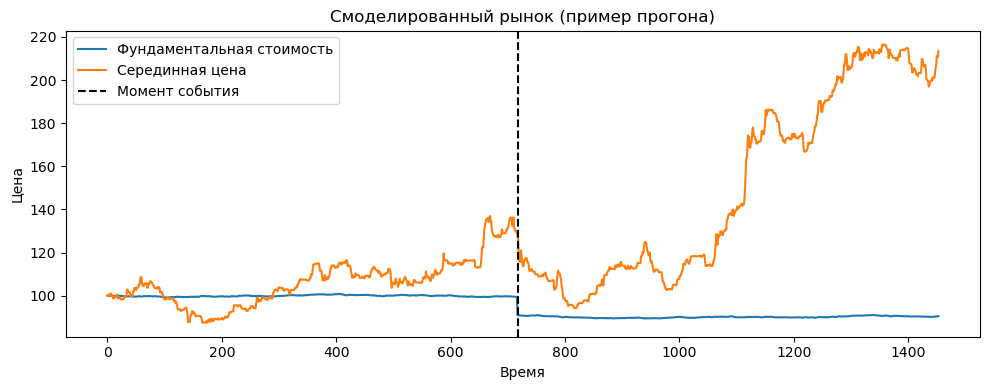

In [12]:
# Пример использования:
config_example = sample_random_config(run_id=0)
results_example = run_simulation(config_example)

fundamental_values = results_example["fundamental_values"]
mid_prices = results_example["mid_prices"]
event_time = config_example.event_time

plt.figure(figsize=(10, 4))
plt.plot(fundamental_values, label="Фундаментальная стоимость")
plt.plot(mid_prices, label="Серединная цена")
if config_example.has_event and event_time is not None:
    plt.axvline(event_time, color="k", linestyle="--", label="Момент события")
plt.title("Смоделированный рынок (пример прогона)")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
trades_df_example = results_example["trades_df"]
print("Первые несколько сделок:")
trades_df_example.head()

Первые несколько сделок:


,time,price,quantity,buy_agent,sell_agent
0,0,100.05,7,12,9
1,0,100.26,1,12,1
2,0,99.79,10,1,13
3,0,100.26,1,15,1
4,0,100.15,4,23,18


In [14]:
# Сводка P&L по агентам
last_mid = mid_prices[-1]
agents_example = results_example["agents"]
summary_rows = []
for a in agents_example:
    equity = a.cash + a.position * last_mid
    summary_rows.append(
        {
            "agent_id": a.id,
            "type": a.type,
            "label_is_illegal": a.label_is_illegal,
            "label_illegal_type": a.label_illegal_type,
            "group_id": a.group_id,
            "cash": round(a.cash, 2),
            "position": a.position,
            "equity": round(equity, 2),
        }
    )
summary_df_example = pd.DataFrame(summary_rows).sort_values("equity", ascending=False)
print("Сводка по результатам агентов (пример прогона):")
summary_df_example

Сводка по результатам агентов (пример прогона):


,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash,position,equity
32,33,NOISE,False,None,None,-51562.52,477,50293.67
28,29,NOISE,False,None,None,-57281.71,478,44788.02
34,35,NOISE,False,None,None,-17976.65,253,36047.70
16,17,NOISE,False,None,None,-42881.56,367,35485.79
29,30,NOISE,False,None,None,-53830.71,418,35426.92
22,23,NOISE,False,None,None,-39408.72,324,29776.62
10,11,NOISE,False,None,None,-12003.70,172,24724.32
4,5,NOISE,False,None,None,-19450.47,189,20907.65
20,21,NOISE,False,None,None,-18525.17,173,18416.39
23,24,NOISE,False,None,None,-37408.01,261,18324.63


## Извлечение признаков для задач машинного обучения
Чтобы обучать модель обнаружения нарушителей, нужно преобразовать сырые сделки
и цены в **табличные признаки**.

Мы делаем это на двух уровнях:
1. **Уровень агента** (одна строка на агента в каждом прогоне):
   - общий объём, количество сделок, чистый объём, объём покупок и продаж;
   - объём до события и после события;
   - объём, направленный **в соответствии со знаком события**
     (для прогонов с фундаментальным скачком);
   - конечные денежные средства, позиция и совокупная стоимость портфеля.
2. **Уровень временных окон** (одна строка на окно в каждом прогоне):
   - количество сделок и общий объём в окне;
   - объём покупок и объём продаж;
   - количество активных агентов;
   - реализованная волатильность;
   - индикатор того, были ли в окне сделки незаконных агентов.

Эти признаки вычисляются на основе **по-сделочной информации**
с помощью вспомогательных функций.

In [15]:
def build_agent_trade_table(trades_df: pd.DataFrame) -> pd.DataFrame:
    """
    Преобразовать таблицу сделок в таблицу на уровне агентов:
    одна строка на пару (сделка, агент, сторона).
    """
    rows: List[Dict[str, Any]] = []
    if trades_df is None or trades_df.empty:
        return pd.DataFrame(columns=["time", "agent_id", "side", "quantity", "price"])

    for _, tr in trades_df.iterrows():
        rows.append(
            {
                "time": int(tr["time"]),
                "agent_id": int(tr["buy_agent"]),
                "side": "BUY",
                "quantity": float(tr["quantity"]),
                "price": float(tr["price"]),
            }
        )
        rows.append(
            {
                "time": int(tr["time"]),
                "agent_id": int(tr["sell_agent"]),
                "side": "SELL",
                "quantity": float(tr["quantity"]),
                "price": float(tr["price"]),
            }
        )
    return pd.DataFrame(rows)


def extract_agent_features(
        run_id: int,
        agents: List[Agent],
        trades_df: pd.DataFrame,
        config: SimulationConfig,
        mid_prices: np.ndarray,
) -> pd.DataFrame:
    """
    Вычислить агрегированные признаки на уровне агента
    для задач обнаружения нарушителей.
    """
    agent_trade_df = build_agent_trade_table(trades_df)
    agent_trade_df["run_id"] = run_id

    event_time = config.event_time if config.has_event else None
    event_direction = config.jump_direction if config.has_event else 0

    rows: List[Dict[str, Any]] = []

    last_mid = mid_prices[-1] if len(mid_prices) > 0 else 100.0

    for a in agents:
        at = agent_trade_df[agent_trade_df["agent_id"] == a.id]

        n_trades = len(at)
        total_volume = float(at["quantity"].sum()) if n_trades > 0 else 0.0

        # Подписанный объём (BUY — положительный, SELL — отрицательный)
        if n_trades > 0:
            signed = np.where(at["side"] == "BUY", at["quantity"], -at["quantity"])
            net_volume = float(signed.sum())
        else:
            net_volume = 0.0

        # Объём до события и после события
        if event_time is not None:
            pre = at[at["time"] < event_time]
            post = at[at["time"] >= event_time]
            pre_vol = float(pre["quantity"].sum())
            post_vol = float(post["quantity"].sum())

            # Объём, направленный в сторону события:
            # - если event_direction > 0 (позитивное событие), «выравненный» объём —
            #   чистый объём покупок до события;
            # - если event_direction < 0 (негативное событие), «выравненный» объём —
            #   чистый объём продаж до события.
            if event_direction != 0 and len(pre) > 0:
                pre_signed = np.where(pre["side"] == "BUY", pre["quantity"], -pre["quantity"])
                aligned = pre_signed if event_direction > 0 else -pre_signed
                aligned_pre_vol = float(aligned[aligned > 0].sum())
            else:
                aligned_pre_vol = 0.0
        else:
            pre_vol = post_vol = aligned_pre_vol = 0.0

        # Средний размер сделки
        avg_trade_size = float(at["quantity"].mean()) if n_trades > 0 else 0.0

        # Разделение на покупки и продажи
        buy_vol = float(at.loc[at["side"] == "BUY", "quantity"].sum()) if n_trades > 0 else 0.0
        sell_vol = float(at.loc[at["side"] == "SELL", "quantity"].sum()) if n_trades > 0 else 0.0

        # Итоговая стоимость портфеля (equity)
        equity = a.cash + a.position * last_mid

        rows.append(
            {
                "run_id": run_id,
                "agent_id": a.id,
                "type": a.type,
                "label_is_illegal": a.label_is_illegal,
                "label_illegal_type": a.label_illegal_type,
                "group_id": a.group_id,
                "cash_final": float(a.cash),
                "position_final": int(a.position),
                "equity_final": float(equity),
                "n_trades": int(n_trades),
                "total_volume": total_volume,
                "net_volume": net_volume,
                "avg_trade_size": avg_trade_size,
                "buy_volume": buy_vol,
                "sell_volume": sell_vol,
                "pre_event_volume": pre_vol,
                "post_event_volume": post_vol,
                "aligned_pre_event_volume": aligned_pre_vol,
            }
        )

    return pd.DataFrame(rows)


def extract_window_features(
        run_id: int,
        agents: List[Agent],
        trades_df: pd.DataFrame,
        config: SimulationConfig,
        mid_prices: np.ndarray,
        window_size: int = 50,
) -> pd.DataFrame:
    """
    Вычислить признаки и метки на уровне последовательных непересекающихся
    временных окон: по одной строке на окно.
    """
    if len(mid_prices) == 0:
        return pd.DataFrame()

    illegal_ids = {a.id for a in agents if a.label_is_illegal}
    if trades_df is None:
        trades_df = pd.DataFrame(columns=["time", "quantity", "buy_agent", "sell_agent"])

    T = len(mid_prices)
    # Логарифмические доходности с небольшим сдвигом для численной устойчивости
    returns = np.diff(np.log(mid_prices + 1e-8))

    rows: List[Dict[str, Any]] = []

    event_time = config.event_time if config.has_event else None

    n_windows = T // window_size

    for w in range(n_windows):
        start = w * window_size
        end = start + window_size

        # Сделки в данном окне
        mask = (trades_df["time"] >= start) & (trades_df["time"] < end)
        w_trades = trades_df[mask]

        total_vol = float(w_trades["quantity"].sum()) if not w_trades.empty else 0.0
        n_trades = int(len(w_trades))

        # Число различных агентов, торговавших в окне
        if not w_trades.empty:
            agents_in_window = set(w_trades["buy_agent"]).union(set(w_trades["sell_agent"]))
        else:
            agents_in_window = set()

        # Были ли в окне активны незаконные агенты?
        has_illegal = int(len(agents_in_window.intersection(illegal_ids)) > 0)

        # Разбалансировка между покупками и продажами (простая версия)
        if not w_trades.empty:
            buy_vol = float(w_trades["quantity"][w_trades["buy_agent"].isin(agents_in_window)].sum())
            sell_vol = float(w_trades["quantity"][w_trades["sell_agent"].isin(agents_in_window)].sum())
        else:
            buy_vol = 0.0
            sell_vol = 0.0

        # Реализованная волатильность в окне
        if end < len(mid_prices):
            w_rets = returns[start: end - 1]
        else:
            w_rets = returns[start:]
        vol = float(np.std(w_rets)) if len(w_rets) > 0 else 0.0

        # Расстояние до события
        if event_time is not None:
            # Временное расстояние между центром окна и моментом события
            center = (start + end) / 2
            event_distance = float(center - event_time)
        else:
            event_distance = 0.0

        rows.append(
            {
                "run_id": run_id,
                "window_index": w,
                "start_time": start,
                "end_time": end,
                "n_trades": n_trades,
                "total_volume": total_vol,
                "buy_volume": buy_vol,
                "sell_volume": sell_vol,
                "n_active_agents": int(len(agents_in_window)),
                "realized_volatility": vol,
                "has_illegal_activity": has_illegal,
                "event_distance": event_distance,
            }
        )

    return pd.DataFrame(rows)

## Генератор набора данных по множеству сценариев
Функция `generate_dataset` многократно:
1. Сэмплирует случайную конфигурацию через `sample_random_config`.
2. Запускает симуляцию.
3. Извлекает:
   - признаки на уровне агентов для данного прогона;
   - признаки на уровне временных окон для данного прогона.

Затем она объединяет все прогоны в две большие таблицы:
- `agent_level`: каждая строка соответствует одному агенту в одном прогоне,
  содержит метки вроде `label_is_illegal`;
- `window_level`: каждая строка соответствует одному временному окну в одном прогоне,
  с меткой `has_illegal_activity`.

Это наш **синтетический набор данных** для обучения и тестирования моделей.

In [16]:
def generate_dataset(
        n_runs: int = 20,
        window_size: int = 50,
) -> Dict[str, pd.DataFrame]:
    """
    Сгенерировать набор данных по нескольким случайным симуляциям.

    Возвращает словарь:
        {
            "agent_level": pd.DataFrame,
            "window_level": pd.DataFrame,
        }
    """
    agent_rows_all: List[pd.DataFrame] = []
    window_rows_all: List[pd.DataFrame] = []

    for run_id in range(n_runs):
        config = sample_random_config(run_id=run_id)
        results = run_simulation(config)

        agents = results["agents"]
        trades_df = results["trades_df"]
        mid_prices = results["mid_prices"]

        agent_df = extract_agent_features(
            run_id=run_id,
            agents=agents,
            trades_df=trades_df,
            config=config,
            mid_prices=mid_prices,
        )
        window_df = extract_window_features(
            run_id=run_id,
            agents=agents,
            trades_df=trades_df,
            config=config,
            mid_prices=mid_prices,
            window_size=window_size,
        )

        agent_rows_all.append(agent_df)
        window_rows_all.append(window_df)

    # Отфильтровываем пустые таблицы, чтобы избежать FutureWarning от concat
    agent_frames = [df for df in agent_rows_all if df is not None and not df.empty]
    window_frames = [df for df in window_rows_all if df is not None and not df.empty]

    agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()
    window_level = pd.concat(window_frames, ignore_index=True) if window_frames else pd.DataFrame()

    return {
        "agent_level": agent_level,
        "window_level": window_level,
    }

## Быстрая проверка сгенерированного набора данных
Перед обучением модели полезно быстро проверить структуру данных:
- размеры таблиц `agent_level` и `window_level`;
- небольшой фрагмент каждой таблицы, чтобы увидеть названия столбцов
  и порядок величин.

Такая проверка здравого смысла особенно важна, когда набор данных
собирается программно.

In [17]:
example_data = generate_dataset(n_runs=10, window_size=50)
agent_df_example = example_data["agent_level"]
window_df_example = example_data["window_level"]

print("Размерность набора данных на уровне агентов:", agent_df_example.shape)
print("Размерность набора данных на уровне окон:", window_df_example.shape)

Размерность набора данных на уровне агентов: (230, 18)
Размерность набора данных на уровне окон: (202, 12)


/var/folders/92/b0fqb65132x3sm8hswbm4y9r0000gn/T/ipykernel_43727/1819847211.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()


In [18]:
print("\nПример строк (agent-level):")
agent_df_example.head()


Пример строк (agent-level):


,run_id,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash_final,position_final,equity_final,n_trades,total_volume,net_volume,avg_trade_size,buy_volume,sell_volume,pre_event_volume,post_event_volume,aligned_pre_event_volume
0,0,1,MM,False,None,NaN,-5570.58,28,-5227.440,4165,27436.0,28.0,6.587275,13732.0,13704.0,0.0,0.0,0.0
1,0,2,PROP,False,None,NaN,-12128.73,390,-7349.280,641,4422.0,390.0,6.898596,2406.0,2016.0,0.0,0.0,0.0
2,0,3,PROP,False,None,NaN,4097.73,3,4134.495,479,2309.0,3.0,4.820459,1156.0,1153.0,0.0,0.0,0.0
3,0,4,NOISE,False,None,NaN,14292.24,-437,8936.805,713,4445.0,-437.0,6.234222,2004.0,2441.0,0.0,0.0,0.0
4,0,5,NOISE,False,None,NaN,15105.70,-378,10473.310,650,3834.0,-378.0,5.898462,1728.0,2106.0,0.0,0.0,0.0


In [19]:
print("Пример строк (window-level):")
window_df_example.head()

Пример строк (window-level):


,run_id,window_index,start_time,end_time,n_trades,total_volume,buy_volume,sell_volume,n_active_agents,realized_volatility,has_illegal_activity,event_distance
0,0,0,0,50,268,1417.0,1417.0,1417.0,19,0.005108,0,0.0
1,0,1,50,100,189,1243.0,1243.0,1243.0,19,0.022102,0,0.0
2,0,2,100,150,252,1426.0,1426.0,1426.0,19,0.007557,0,0.0
3,0,3,150,200,245,1278.0,1278.0,1278.0,19,0.005886,0,0.0
4,0,4,200,250,221,1211.0,1211.0,1211.0,19,0.004458,0,0.0


## Визуализация поведения инсайдеров
Чтобы лучше понять, как ведут себя незаконные агенты в симуляции, добавим два
вспомогательных инструмента визуализации:
1. `plot_price_with_insider_trades(results)`
   - строит серединную цену и фундаментальную стоимость;
   - накладывает сделки **незаконных агентов** (покупки/продажи) в виде точек
     во времени и по цене;
   - отмечает момент фундаментального события, если оно есть.
2. `plot_insider_positions(results)`
   - восстанавливает **временной ряд позиции** каждого незаконного агента;
   - строит эти траектории и отмечает момент события.
Эти визуализации позволяют студентам увидеть, как разные типы стратегий
(инсайдер перед событием, «медленный» инсайдер, «скрытный» инсайдер,
манипулятор «накачка–сброс») выглядят в терминах фактических сделок
и динамики позиций.

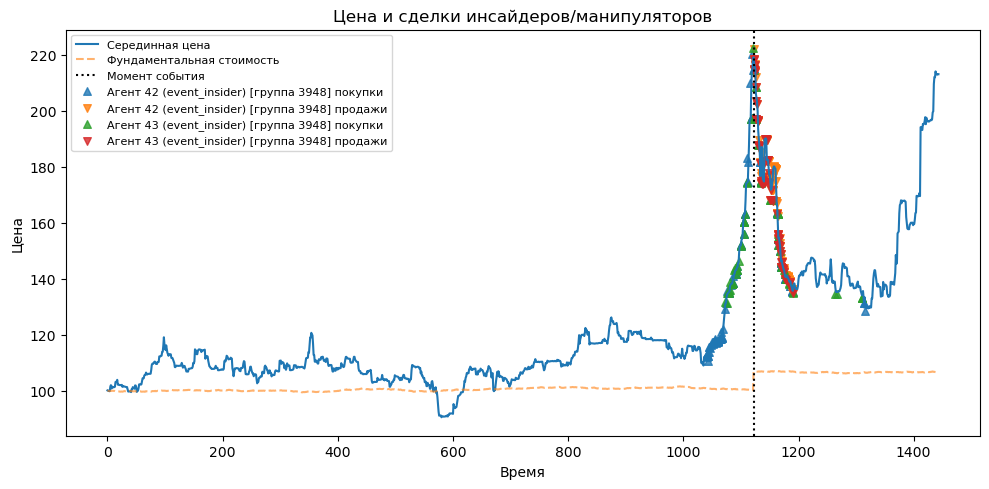

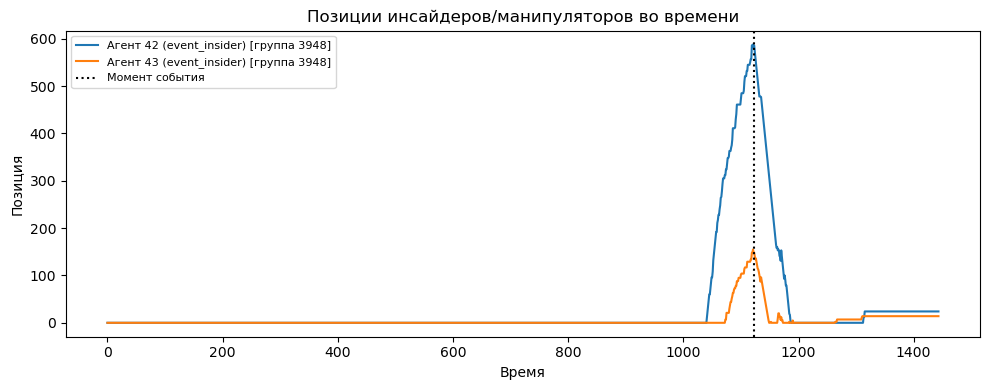

In [20]:
def plot_price_with_insider_trades(results: Dict[str, Any]):
    """
    Построить серединную цену и фундаментальную стоимость
    и наложить отдельные сделки инсайдеров (покупки/продажи) точками.

    results: словарь, возвращаемый функцией run_simulation(...)
    """
    config = results["config"]
    fundamental_values = results["fundamental_values"]
    mid_prices = results["mid_prices"]
    trades_df = results["trades_df"]
    agents = results["agents"]

    illegal_agents = [a for a in agents if a.label_is_illegal]
    if not illegal_agents:
        print("В этом прогоне нет незаконных/инсайдерских агентов.")
        return None, None

    fig, ax = plt.subplots(figsize=(10, 5))

    # Основные ценовые ряды
    ax.plot(mid_prices, label="Серединная цена")
    ax.plot(fundamental_values, label="Фундаментальная стоимость", linestyle="--", alpha=0.6)

    # Момент события, если он есть
    if config.has_event and config.event_time is not None:
        ax.axvline(config.event_time, color="k", linestyle=":", label="Момент события")

    if trades_df is None or trades_df.empty:
        ax.set_title("Нет сделок для отображения")
        ax.set_xlabel("Время")
        ax.set_ylabel("Цена")
        ax.legend()
        fig.tight_layout()
        return fig, ax

    # Переходим к таблице сделок на уровне агентов
    agent_trades = build_agent_trade_table(trades_df)

    for a in illegal_agents:
        df_a = agent_trades[agent_trades["agent_id"] == a.id]
        if df_a.empty:
            continue

        buys = df_a[df_a["side"] == "BUY"]
        sells = df_a[df_a["side"] == "SELL"]

        base_label = f"Агент {a.id} ({a.label_illegal_type})"
        if a.group_id is not None:
            base_label += f" [группа {a.group_id}]"

        if not buys.empty:
            ax.scatter(
                buys["time"],
                buys["price"],
                marker="^",
                s=30,
                alpha=0.8,
                label=base_label + " покупки",
            )
        if not sells.empty:
            ax.scatter(
                sells["time"],
                sells["price"],
                marker="v",
                s=30,
                alpha=0.8,
                label=base_label + " продажи",
            )

    ax.set_xlabel("Время")
    ax.set_ylabel("Цена")
    ax.set_title("Цена и сделки инсайдеров/манипуляторов")
    ax.legend(loc="best", fontsize=8)
    fig.tight_layout()
    return fig, ax


def plot_insider_positions(results: Dict[str, Any]):
    """
    Построить временные ряды позиций всех незаконных/инсайдерских агентов в прогоне.

    results: словарь, возвращаемый функцией run_simulation(...)
    """
    config = results["config"]
    agents = results["agents"]
    trades_df = results["trades_df"]
    mid_prices = results["mid_prices"]
    T = len(mid_prices)

    illegal_agents = [a for a in agents if a.label_is_illegal]
    if not illegal_agents:
        print("В этом прогоне нет незаконных/инсайдерских агентов.")
        return None, None

    if trades_df is None or trades_df.empty:
        print("В этом прогоне нет сделок, невозможно построить динамику позиций.")
        return None, None

    agent_trades = build_agent_trade_table(trades_df)

    fig, ax = plt.subplots(figsize=(10, 4))

    for a in illegal_agents:
        df_a = agent_trades[agent_trades["agent_id"] == a.id].copy()
        if df_a.empty:
            continue

        # Пошагово восстанавливаем ряд позиции во времени
        pos = np.zeros(T)
        running_pos = 0.0

        # Группируем сделки по времени для более быстрых обновлений
        trades_by_time = {
            int(t): grp for t, grp in df_a.groupby("time")
        }

        for t in range(T):
            if t in trades_by_time:
                g = trades_by_time[t]
                signed = np.where(g["side"] == "BUY", g["quantity"], -g["quantity"])
                running_pos += signed.sum()
            pos[t] = running_pos

        label = f"Агент {a.id} ({a.label_illegal_type})"
        if a.group_id is not None:
            label += f" [группа {a.group_id}]"
        ax.plot(pos, label=label)

    if config.has_event and config.event_time is not None:
        ax.axvline(config.event_time, color="k", linestyle=":", label="Момент события")

    ax.set_xlabel("Время")
    ax.set_ylabel("Позиция")
    ax.set_title("Позиции инсайдеров/манипуляторов во времени")
    ax.legend(loc="best", fontsize=8)
    fig.tight_layout()
    return fig, ax


# Примеры
config_example = sample_random_config(run_id=0)
results_example = run_simulation(config_example)

fig1, ax1 = plot_price_with_insider_trades(results_example)
fig2, ax2 = plot_insider_positions(results_example)

## Подготовка набора данных на уровне агентов для обучения
Теперь используем наш симуляционный движок, чтобы построить набор данных
для задачи контролируемого обучения:
1. Генерируем множество прогонов с помощью `generate_dataset`.
2. Берём только таблицу `agent_level`.
3. Отбрасываем агентов, которые ни разу не торговали (`n_trades == 0`).
4. Определяем:
   - целевую переменную `y = label_is_illegal` (0 — легальный, 1 — нарушитель);
   - матрицу признаков `X` только из количественных поведенческих столбцов.
5. Делим по `run_id` на:
   - обучающие прогоны;
   - тестовые прогоны (полностью другие сценарии).

Такой подход гарантирует, что модель тестируется на **новых рынках**,
а не просто на новых агентах в уже «знакомом» сценарии.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [22]:
# Генерируем более крупный набор данных для обучения (при необходимости измените n_runs)
ml_data = generate_dataset(n_runs=250, window_size=50)
agent_df = ml_data["agent_level"].copy()

print("Полная размерность набора данных на уровне агентов:", agent_df.shape)
print("Распределение метки незаконности (label_is_illegal):")
print(agent_df["label_is_illegal"].value_counts(normalize=True))

Полная размерность набора данных на уровне агентов: (6968, 18)
Распределение метки незаконности (label_is_illegal):
label_is_illegal
False    0.958238
True     0.041762
Name: proportion, dtype: float64


/var/folders/92/b0fqb65132x3sm8hswbm4y9r0000gn/T/ipykernel_43727/1819847211.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agent_level = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()


In [23]:
# Отбрасываем агентов без сделок (они почти не несут информации)
agent_df = agent_df[agent_df["n_trades"] > 0].reset_index(drop=True)
print("\nПосле удаления агентов без сделок:", agent_df.shape)


После удаления агентов без сделок: (6968, 18)


In [24]:
# Определяем признаки и целевую переменную
label_col = "label_is_illegal"
y = agent_df[label_col].astype(int)

drop_cols = [
    "label_is_illegal",
    "label_illegal_type",
    "type",
    "group_id",
    "agent_id",
    "run_id",
]
feature_cols = [c for c in agent_df.columns if c not in drop_cols]
X = agent_df[feature_cols]

print("Используемые признаки:", feature_cols)

Используемые признаки: ['cash_final', 'position_final', 'equity_final', 'n_trades', 'total_volume', 'net_volume', 'avg_trade_size', 'buy_volume', 'sell_volume', 'pre_event_volume', 'post_event_volume', 'aligned_pre_event_volume']


In [25]:
# Разделение на обучающую и тестовую выборки по run_id (групповой разрез)
unique_runs = agent_df["run_id"].unique()
train_runs, test_runs = train_test_split(
    unique_runs, test_size=0.3, random_state=42
)

train_mask = agent_df["run_id"].isin(train_runs)
test_mask = agent_df["run_id"].isin(test_runs)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Обучающая выборка: {X_train.shape[0]} агентов из {len(train_runs)} прогонов")
print(f"Тестовая выборка:   {X_test.shape[0]} агентов из {len(test_runs)} прогонов")

Обучающая выборка: 4922 агентов из 175 прогонов
Тестовая выборка:   2046 агентов из 75 прогонов


## Обучение и оценка классификатора на основе случайного леса
Теперь обучим простую модель:
- стандартизируем признаки с помощью `StandardScaler`;
- обучим классификатор `RandomForestClassifier` со следующими параметрами:
  - `n_estimators=200`;
  - `max_depth=6`;
  - `class_weight='balanced'` — компенсация дисбаланса классов
    (нарушители встречаются реже).

Затем оценим качество модели:
- отчёт по классификации (точность, полнота, F1-мера);
- матрица ошибок;
- показатель ROC AUC (на основе предсказанных вероятностей).

Цель — не тонкая настройка гиперпараметров, а демонстрация того,
что **поведенческие признаки действительно несут сигнал**
о том, кто с большей вероятностью является нарушителем.

In [26]:
# Определяем и обучаем модель
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                random_state=42,
                class_weight="balanced",  # учитываем дисбаланс классов
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\n=== Отчёт по классификации на уровне агентов (тестовая выборка) ===")
print(classification_report(y_test, y_pred, digits=3))


=== Отчёт по классификации на уровне агентов (тестовая выборка) ===
              precision    recall  f1-score   support

           0      0.991     0.970     0.980      1954
           1      0.560     0.815     0.664        92

    accuracy                          0.963      2046
   macro avg      0.775     0.893     0.822      2046
weighted avg      0.972     0.963     0.966      2046



In [27]:
print("Матрица ошибок (строки = истинный класс, столбцы = прогноз):")
print(confusion_matrix(y_test, y_pred))

try:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC на тесте: {auc:.3f}")
except ValueError:
    print("Невозможно вычислить ROC AUC (в y_test присутствует только один класс).")

Матрица ошибок (строки = истинный класс, столбцы = прогноз):
[[1895   59]
 [  17   75]]
ROC AUC на тесте: 0.980


## На какие признаки опирается модель?
Для случайного леса можно оценить **важность признаков** по тому,
насколько каждый признак уменьшает неопределённость (импурити) в деревьях.

Рассмотрим эти важности, чтобы понять:
- какие поведенческие характеристики модель считает наиболее информативными;
- опирается ли модель в основном на узкий набор признаков
  (например, только `n_trades`), или использует более широкий набор
  (объём, чистая позиция, объём, выровненный по направлению события, и т.д.).

In [28]:
rf_model = clf.named_steps["model"]
importances = rf_model.feature_importances_
feat_imp = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("Топ-10 наиболее важных признаков:")
feat_imp.head(10)

Топ-10 наиболее важных признаков:


,feature,importance
3,n_trades,0.187871
1,position_final,0.138007
5,net_volume,0.109833
9,pre_event_volume,0.094590
7,buy_volume,0.085133
8,sell_volume,0.082706
4,total_volume,0.074645
11,aligned_pre_event_volume,0.069358
0,cash_final,0.052604
6,avg_trade_size,0.041573


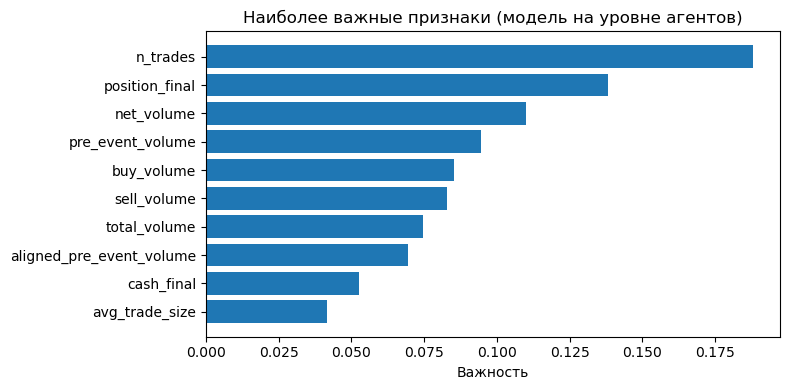

In [29]:
plt.figure(figsize=(8, 4))
top_n = 10
plt.barh(
    feat_imp["feature"].head(top_n)[::-1],
    feat_imp["importance"].head(top_n)[::-1],
)
plt.title("Наиболее важные признаки (модель на уровне агентов)")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

## Интерпретация модели: насколько важен признак `n_trades`?
График важности признаков показывает, что `n_trades` — один из самых важных
(а часто и самый важный) признак.
Чтобы понять это более детально, сделаем два шага:
1. Изучим **распределение `n_trades` по классам**:
   - посчитаем описательные статистики отдельно для легальных и незаконных агентов;
   - построим ящик с усами (boxplot) `n_trades` в разрезе метки `label_is_illegal`.
2. Переобучим модель **без признака** `n_trades`:
   - сравним отчёт по классификации и ROC AUC с исходной моделью;
   - посмотрим, насколько сильно упадёт качество.

Это важный дидактический момент:
- очень «важный» признак может использоваться моделью как грубый фильтр
  исключения («крайне активный участник скорее похож на маркет-мейкера,
  чем на скрытого инсайдера»);
- удаление такого признака показывает, умеет ли модель использовать
  более тонкие поведенческие паттерны (чистые объёмы, объём в сторону события и т.п.).

In [30]:
# Описательная статистика n_trades по классам
agent_df.groupby("label_is_illegal")["n_trades"].describe()

,count,mean,std,min,25%,50%,75%,max
label_is_illegal,,,,,,,,
False,6677.0,592.373072,790.678042,82.0,281.0,408.0,567.0,7389.0
True,291.0,180.285223,80.601474,39.0,118.5,174.0,227.5,398.0


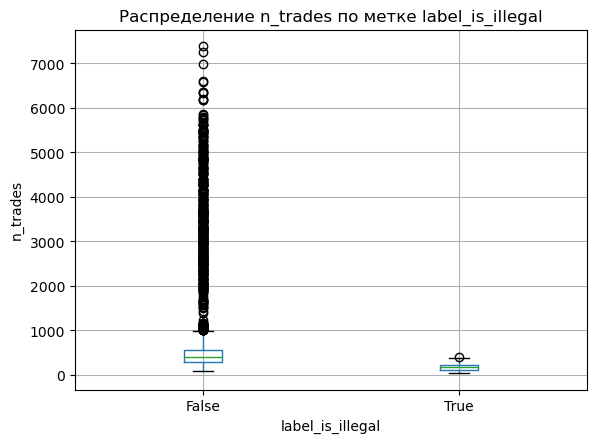

In [31]:
# Визуализация распределения n_trades
agent_df.boxplot(column="n_trades", by="label_is_illegal")
plt.suptitle("")
plt.title("Распределение n_trades по метке label_is_illegal")
plt.xlabel("label_is_illegal")
plt.ylabel("n_trades")
plt.show()

In [32]:
# Переобучение модели без признака n_trades
X_no_n = agent_df[[c for c in feature_cols if c != "n_trades"]]

X_train_no_n, X_test_no_n = X_no_n[train_mask], X_no_n[test_mask]

clf_no_n = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=6,
            random_state=42,
            class_weight="balanced",
        )),
    ]
)

clf_no_n.fit(X_train_no_n, y_train)
y_pred_no_n = clf_no_n.predict(X_test_no_n)
y_proba_no_n = clf_no_n.predict_proba(X_test_no_n)[:, 1]

print("Отчёт по классификации без признака n_trades:")
print(classification_report(y_test, y_pred_no_n, digits=3))
print("ROC AUC (без признака n_trades):", roc_auc_score(y_test, y_proba_no_n))

Отчёт по классификации без признака n_trades:
              precision    recall  f1-score   support

           0      0.990     0.965     0.977      1954
           1      0.514     0.783     0.621        92

    accuracy                          0.957      2046
   macro avg      0.752     0.874     0.799      2046
weighted avg      0.968     0.957     0.961      2046

ROC AUC (без признака n_trades): 0.9782386186640559
